# Explore BPZ photo-z's using friends-of-friends catalog matching

Owners: HyeYun Park, Bela Abolfathi, Imran Hasan, Erfan Nourbakhsh, Adam Broussard  <br>
Last Verified to Run: 2019-01-02

This notebook is adapted from `matching_fof.ipynb` to test the performance of photo-z's derived from BPZ. See the  `object_gcr_4_photoz.ipynb` notebook for  a more in-depth tutorial on how to access the photo-z data.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import FoFCatalogMatching
import GCRCatalogs

In [3]:
#Load the DC2 object catalog, with BPZ photo-z's in the `photoz_mode` column.
object_cat =  GCRCatalogs.load_catalog('dc2_object_run1.2i_with_photoz')

In [4]:
from GCR import GCRQuery
star_sprinkled_filter = [
    ~GCRQuery('star'),
    ~GCRQuery('sprinkled'),
    ~GCRQuery('agn')
]

In [5]:
# Let's also define a magnitude cut based on LSST gold sample.

mag_filters = [
    (np.isfinite, 'mag_i'),
    'mag_i < 25.0',
]

In [6]:
# Load ra and dec from object, using both of the filters we just defined.
object_data = object_cat.get_quantities(['ra', 'dec', 'objectId', 'photoz_mode'], filters=mag_filters)

In [7]:
# Let's now turn to the truth catalog. Turn off md5 sum check to save time.
truth_cat = GCRCatalogs.load_catalog('dc2_truth_run1.2_static', {'md5': None})

In [8]:
# We see there is no mag_i, but only mag_true_i (i.e., magnitude before lensing), and it maps to `i`
print(truth_cat.get_quantity_modifier('mag_true_i'))

i


In [9]:
# To make our `mag_filters` work, let's define mag_i for the truth catalog
truth_cat.add_quantity_modifier('mag_i', 'i')

In [10]:
# Get ra and dec from truth catalog
# Note that we add i < 25.0 to the native filter to speed up load time
truth_native_filters = (['i < 25.0'])
truth_data = truth_cat.get_quantities(['ra', 'dec', 'object_id', 'redshift'], filters=star_sprinkled_filter, 
                                                                                       native_filters=truth_native_filters)

In [11]:
print (len(object_data['ra']))
print (len(truth_data['ra']))

1073019
1124435


In [12]:
# Now we can really do the matching!
# FoFCatalogMatching.match takes a dictionary of catalogs to match, a friends-of-friends linking length. 
# Because our "catalog" is not an astropy table or pandas dataframe, 
# `len(truth_coord)` won't give the actual length of the table
# so we need to specify `catalog_len_getter` so that the code knows how to get the length of the catalog.

results = FoFCatalogMatching.match(
    catalog_dict={'truth': truth_data, 'coadd': object_data},
    linking_lengths=1.0,
    catalog_len_getter=lambda x: len(x['ra']),
)

In [13]:
# FoFCatalogMatching.match returns an astropy table
results

row_index,catalog_key,group_id
int64,str5,int64
0,truth,0
419050,coadd,0
1,truth,1
430433,coadd,1
2,truth,2
418880,coadd,2
3,truth,3
423548,coadd,3
4,truth,4


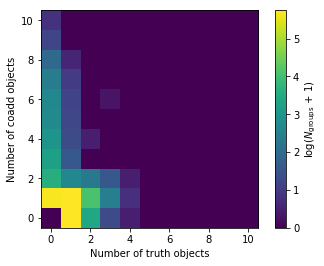

In [14]:
# now we want to count the number of truth and objects *for each group*
# but instead of looping over groups, we can do this in a smart (and very fast) way

# first we need to know which rows are from the truth catalog and which are from the coadd
truth_mask = results['catalog_key'] == 'truth'
object_mask = ~truth_mask

# then np.bincount will give up the number of id occurrences (like histogram but with integer input)
n_groups = results['group_id'].max() + 1
n_truth = np.bincount(results['group_id'][truth_mask], minlength=n_groups)
n_object = np.bincount(results['group_id'][object_mask], minlength=n_groups)

# now n_truth and n_coadd are the number of truth/coadd objects in each group
# we want to make a 2d histrogram of (n_truth, n_coadd). 
n_max = max(n_truth.max(), n_object.max()) + 1
hist_2d = np.bincount(n_object * n_max + n_truth, minlength=n_max*n_max).reshape(n_max, n_max)

plt.imshow(np.log10(hist_2d+1), extent=(-0.5, n_max-0.5, -0.5, n_max-0.5), origin='lower');
plt.xlabel('Number of truth objects');
plt.ylabel('Number of coadd objects');
plt.colorbar(label=r'$\log(N_{\rm groups} \, + \, 1)$');

In [15]:
# let's further inspect the objects in the groups that have 1-to-1 truth/coadd match.

# first, let's find our the IDs of the groups that have 1-to-1 truth/coadd match:
one_to_one_group_mask = np.in1d(results['group_id'], np.flatnonzero((n_truth == 1) & (n_object == 1)))

# and then we can find the row indices in the *original* truth/coadd catalogs for those 1-to-1 groups
truth_idx = results['row_index'][one_to_one_group_mask & truth_mask]
object_idx = results['row_index'][one_to_one_group_mask & object_mask]

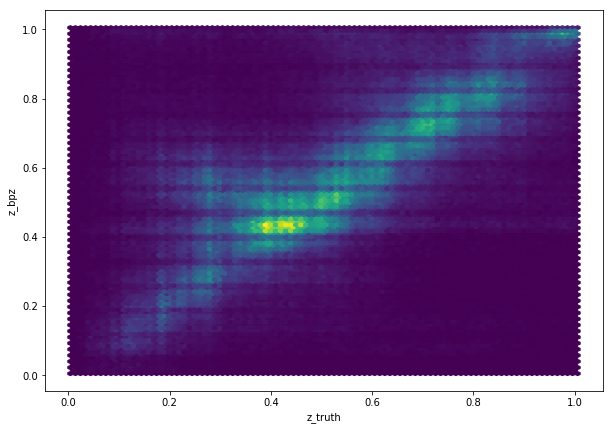

In [16]:
plt.figure(figsize=(10,7))
plt.hexbin(truth_data['redshift'][truth_idx], object_data['photoz_mode'][object_idx])
plt.xlabel('z_truth')
plt.ylabel('z_bpz')
plt.show()